# Credit Card Fraud Detection Model 

In [416]:
# importing everything we will be using 

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#pd.set_option("display.max_rows", None)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [417]:
#importing data

data = pd.read_csv('User0_credit_card_transactions copie.csv')

## Data description 

In [418]:
data.shape
data.columns
data.describe()
data.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object

## Data Cleaning 

In [419]:
data.duplicated().sum()
#data.drop_duplicates() # checking and dropping duplicates 

# NO DUPLICATES

0

In [420]:
# droping the column User because it has too many unique values,the User column had no unique values 
# User is just an index not an ID 

data.drop(['User'], axis=1, inplace=True)

In [421]:
# check for NaN values 
data.isna().sum()

Card                  0
Year                  0
Month                 0
Day                   0
Time                  0
Amount                0
Use Chip              0
Merchant Name         0
Merchant City         0
Merchant State     1317
Zip                1647
MCC                   0
Errors?           19389
Is Fraud?             0
dtype: int64

#### New Date Column 


In [422]:
# add Year, Month , Day to one column Called Date
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
# change the data type of the Date column to object
data['Date'] = data['Date'].astype('object')

#Drop year and day, leave month for analysis 

data.drop(['Year','Day'], axis=1, inplace=True) #keep months 

In [423]:
# create a list of column names in the desired order
column_order = ['Card', 'Date','Month', 'Time', 'Amount', 'Use Chip', 'Merchant Name',
           'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?']

# reorder the columns in the DataFrame
data = data[column_order]

In [424]:
# check for Month where frauds accured the most 
fraud_transactions = data[data['Is Fraud?'] == 'Yes']
# Display the fraudulent transactions based on the 'Time' column
print(fraud_transactions.sort_values(by='Month'))

       Card        Date  Month   Time    Amount            Use Chip  \
17738     3  2016-02-23      2  14:38    $22.40   Swipe Transaction   
17737     3  2016-02-23      2  10:26   $244.23  Online Transaction   
9762      2  2016-03-06      3  12:10   $297.86  Online Transaction   
9761      2  2016-03-06      3  11:18    $81.93    Chip Transaction   
13678     3  2008-10-10     10  09:37    $11.04   Swipe Transaction   
13699     3  2008-10-20     10  09:23  $-298.00   Swipe Transaction   
13698     3  2008-10-20     10  09:03    $29.53   Swipe Transaction   
13690     3  2008-10-13     10  08:13   $196.10   Swipe Transaction   
13689     3  2008-10-13     10  08:10   $245.41   Swipe Transaction   
13688     3  2008-10-13     10  07:08    $75.41   Swipe Transaction   
13687     3  2008-10-13     10  07:02     $3.72   Swipe Transaction   
13685     3  2008-10-12     10  15:58   $298.00   Swipe Transaction   
13684     3  2008-10-12     10  15:54    $96.19   Swipe Transaction   
13683 

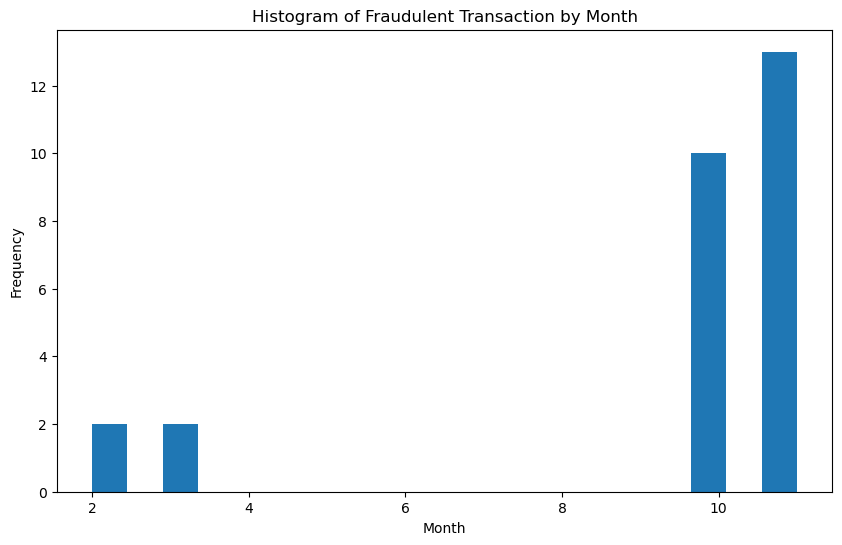

In [425]:
# Sort fraudulent transactions by 'Month'
sorted_fraud_transactions = fraud_transactions.sort_values(by='Month')
# Create a plot of fraudulent transaction over months
plt.figure(figsize=(10, 6))
plt.hist(fraud_transactions['Month'], bins=20)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Histogram of Fraudulent Transaction by Month')
plt.show()

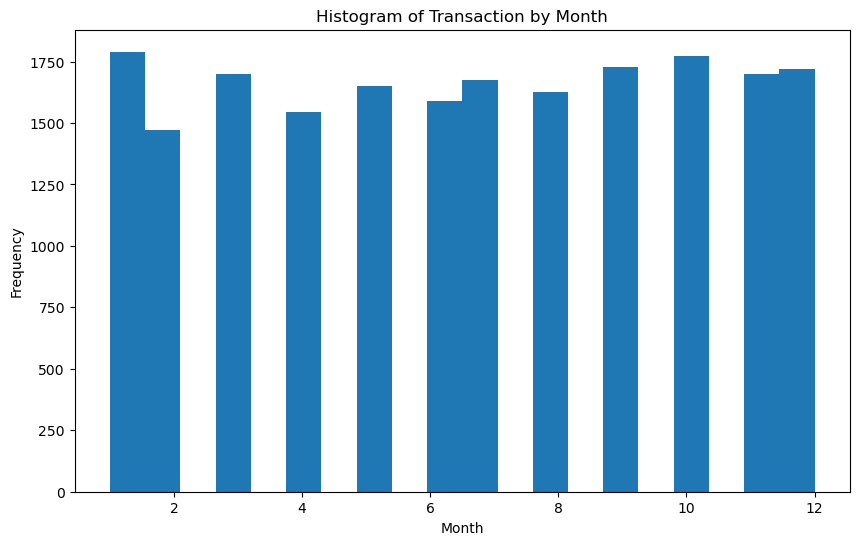

In [426]:
# Create a plot of transaction over months
plt.figure(figsize=(10, 6))
plt.hist(data['Month'], bins=20)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Histogram of Transaction by Month')
plt.show()

### Dealing With column Time

In [427]:
#Add column Morning or Night
# Check which Time most frauds accured, morning or night ? 

data['Time'].min()
data['Time'].max()
# create of function to classify time to morning and night
def classify_store_time(time_str):
    time_obj = pd.to_datetime(time_str).time()
    if time_obj >= datetime.time(9, 0) and time_obj <= datetime.time(17, 0):
        return "Open Hours"
    elif time_obj >= datetime.time(6, 0) and time_obj < datetime.time(9, 0):
        return "Morning"
    elif time_obj >= datetime.time(17, 0) and time_obj <= datetime.time(22, 0):
        return "Evening"
    else:
        return "Night"
data["Time Period"] = data["Time"].apply(classify_store_time)

       Card        Date  Month   Time    Amount            Use Chip  \
13690     3  2008-10-13     10  08:13   $196.10   Swipe Transaction   
13689     3  2008-10-13     10  08:10   $245.41   Swipe Transaction   
13688     3  2008-10-13     10  07:08    $75.41   Swipe Transaction   
13687     3  2008-10-13     10  07:02     $3.72   Swipe Transaction   
4111      0  2015-11-20     11  07:34   $162.11  Online Transaction   
4112      0  2015-11-20     11  07:42  $-473.00  Online Transaction   
4099      0  2015-11-15     11  12:55   $287.13  Online Transaction   
13699     3  2008-10-20     10  09:23  $-298.00   Swipe Transaction   
13698     3  2008-10-20     10  09:03    $29.53   Swipe Transaction   
13685     3  2008-10-12     10  15:58   $298.00   Swipe Transaction   
13684     3  2008-10-12     10  15:54    $96.19   Swipe Transaction   
13683     3  2008-10-12     10  11:52    $68.86   Swipe Transaction   
13678     3  2008-10-10     10  09:37    $11.04   Swipe Transaction   
9762  

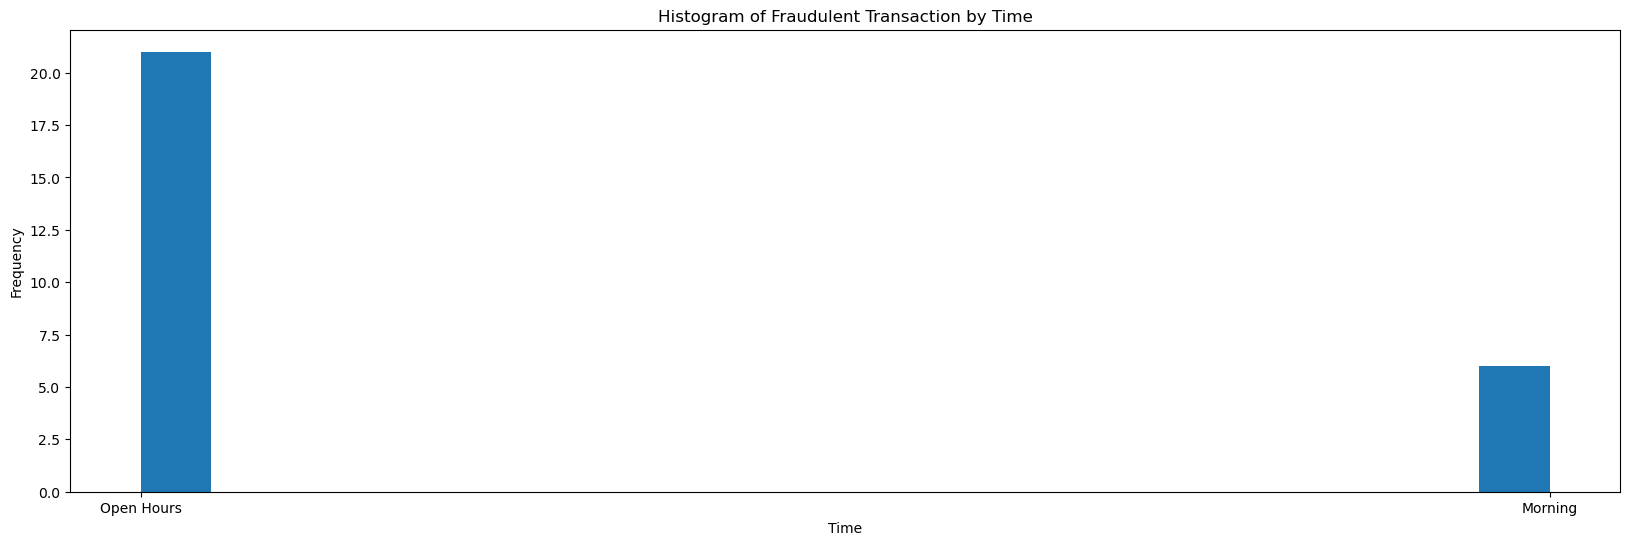

In [428]:
# check for Time where frauds accured the most 
fraud_transactions = data[data['Is Fraud?'] == 'Yes']
# Display the fraudulent transactions based on the 'Time' column
print(fraud_transactions.sort_values(by='Time Period'))
# Sort fraudulent transactions by 'Time'
sorted_fraud_transactions = fraud_transactions.sort_values(by='Time Period')
# Create a plot of fraudulent transaction over Time
plt.figure(figsize=(20, 6))
plt.hist(fraud_transactions['Time Period'], bins=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of Fraudulent Transaction by Time')
plt.show()

#### Dealing with Column amount

In [429]:
## clean column Amount, remove the $ sign 
data['Amount'] = data['Amount'].str.replace('$', '').astype(float).round(0)

       Card        Date  Month   Time  Amount            Use Chip  \
4112      0  2015-11-20     11  07:42  -473.0  Online Transaction   
13699     3  2008-10-20     10  09:23  -298.0   Swipe Transaction   
4100      0  2015-11-15     11  13:19     2.0  Online Transaction   
13687     3  2008-10-13     10  07:02     4.0   Swipe Transaction   
13678     3  2008-10-10     10  09:37    11.0   Swipe Transaction   
4109      0  2015-11-17     11  16:05    18.0  Online Transaction   
17738     3  2016-02-23      2  14:38    22.0   Swipe Transaction   
13698     3  2008-10-20     10  09:03    30.0   Swipe Transaction   
4105      0  2015-11-16     11  13:44    45.0  Online Transaction   
4101      0  2015-11-16     11  09:41    51.0  Online Transaction   
4106      0  2015-11-17     11  14:12    65.0  Online Transaction   
13683     3  2008-10-12     10  11:52    69.0   Swipe Transaction   
13688     3  2008-10-13     10  07:08    75.0   Swipe Transaction   
9761      2  2016-03-06      3  11

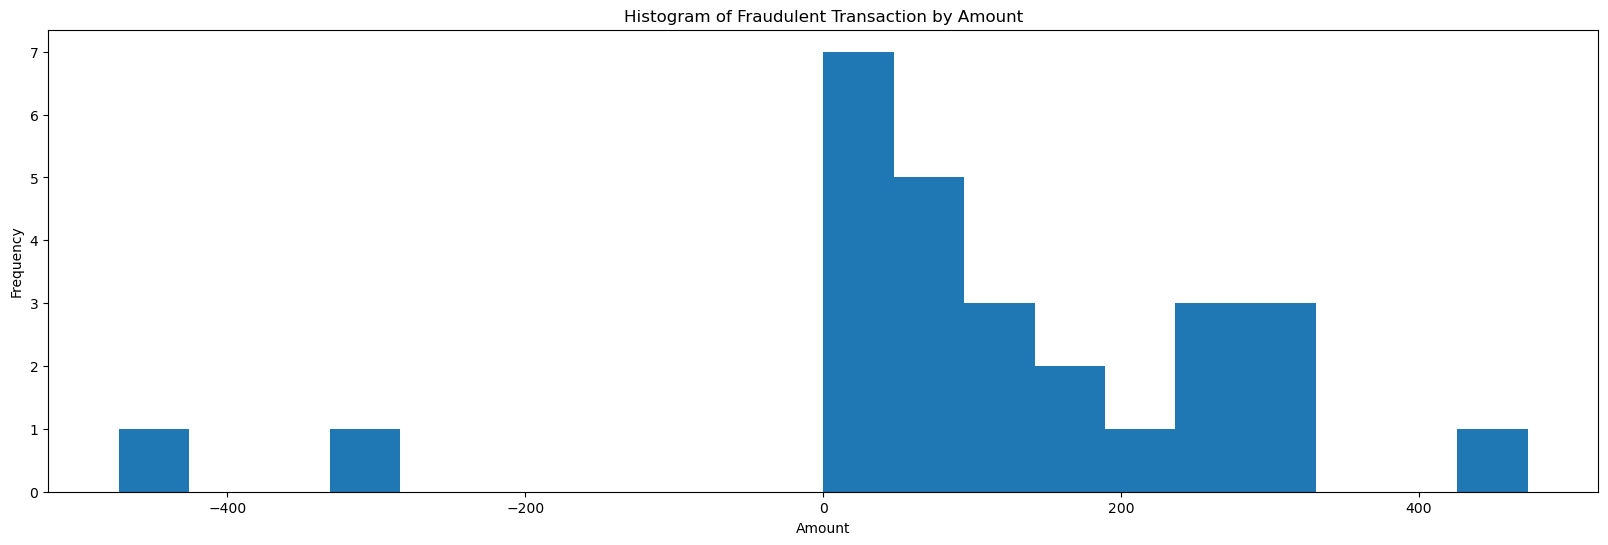

In [430]:
## Check the limit, where most frauds accured, more than X number 
# check for Amount where frauds accured the most 
fraud_transactions = data[data['Is Fraud?'] == 'Yes']
# Display the fraudulent transactions based on the 'Time' column
print(fraud_transactions.sort_values(by='Amount'))
# Sort fraudulent transactions by 'Time'
sorted_fraud_transactions = fraud_transactions.sort_values(by='Amount')
# Create a plot of fraudulent transaction over Time
plt.figure(figsize=(20, 6))
plt.hist(fraud_transactions['Amount'], bins=20)
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Fraudulent Transaction by Amount')
plt.show()

(array([4.000e+00, 1.000e+00, 5.000e+00, 6.000e+00, 6.000e+00, 5.000e+00,
        3.000e+00, 7.000e+00, 2.000e+00, 8.000e+00, 1.000e+00, 4.000e+00,
        5.000e+00, 5.000e+00, 5.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 8.000e+00,
        8.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 5.000e+00, 6.000e+00,
        3.000e+00, 7.000e+00, 4.000e+00, 7.000e+00, 5.000e+00, 5.000e+00,
        6.000e+00, 4.000e+00, 7.000e+00, 3.000e+00, 4.000e+00, 2.600e+01,
        9.800e+01, 8.900e+01, 7.900e+01, 8.800e+01, 8.300e+01, 9.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.940e+02, 1.411e+03,
        5.780e+02, 1.411e+03, 2.307e+03, 1.302e+03, 1.116e+03, 1.089e+03,
        7.790e+02, 7.270e+02, 6.700e+02, 5.250e+02, 1.229e+03, 1.220e+03,
        1.223e+03, 8.160e+02, 7.240e+02, 4.390e+02, 2.880e+02, 1.790e+02,
        1.240e+02, 7.300e+01, 6.500e+01, 3.500e+01, 2.100e+01, 2.000e+01,
        1.300e+01, 1.500e+01, 2.100e+0

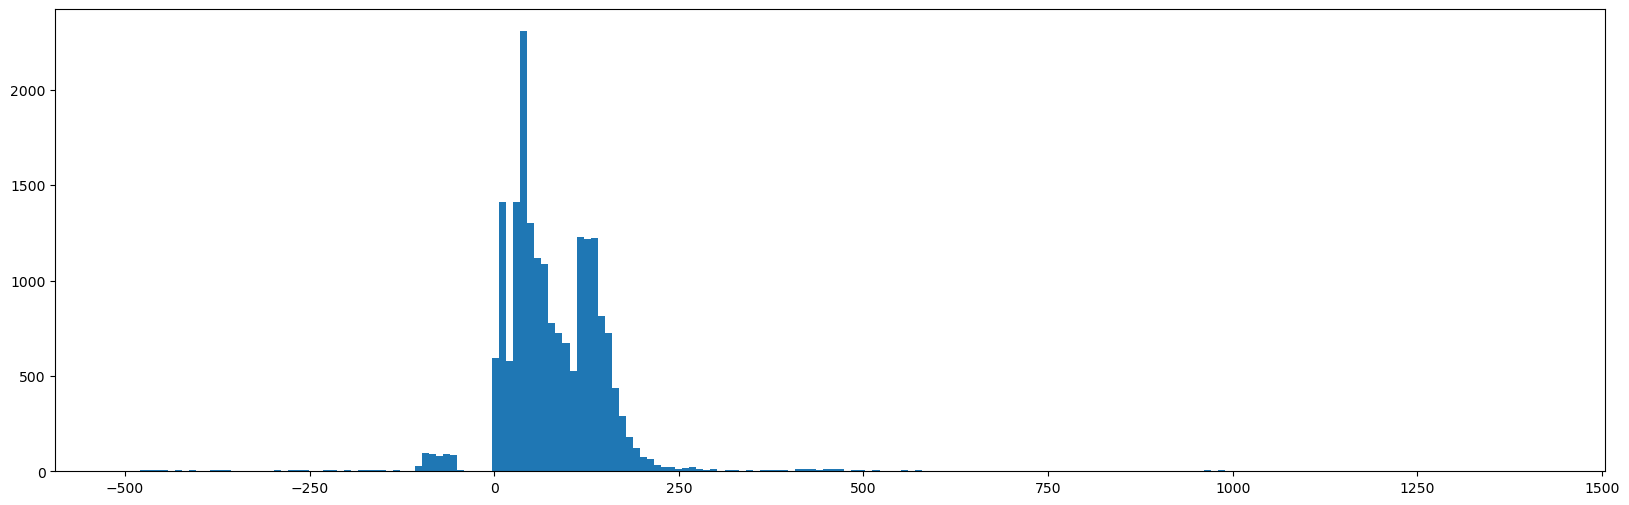

In [431]:
## Plot for Amount 
# Create a plot of transaction Amounts
plt.figure(figsize=(20, 6))
plt.hist(data['Amount'], bins=200)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd7ea83c160>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd7ea83c700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd7ea85ce50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd7ea83cca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd7ea83cf70>],
 'means': []}

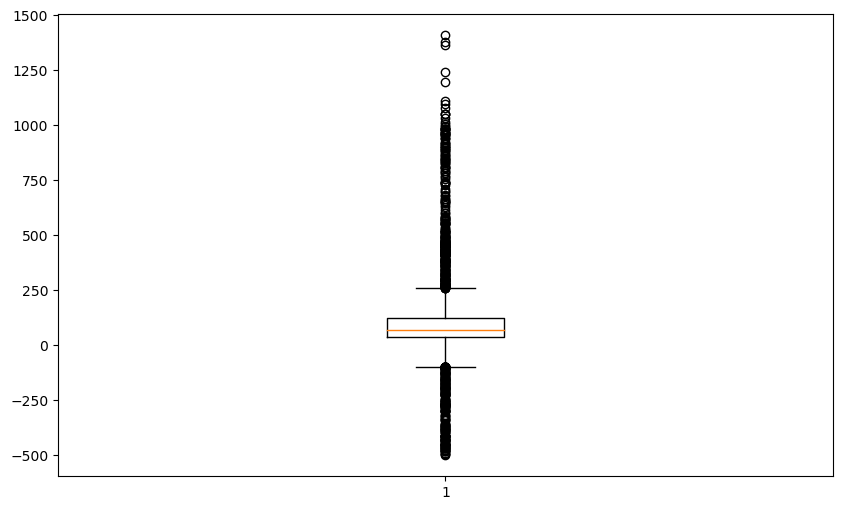

In [432]:
## Check for outliers 
plt.figure(figsize=(10, 6))
plt.boxplot(data['Amount'])

In [433]:
## creating a new column for amount range 
data['Amount_Range'] = np.where(data['Amount'] < 0, 'Less than Zero',
                              np.where(data['Amount'] <= 200, '0-200',
                                       'More than 200'))

#### Cleaning Merchant city : add column to type of transaction ( online or in-person )   

In [434]:
# create a function to categorize merchant type to online and in-person
def categorize_merchant(city):
    if city == 'ONLINE':
        return 'online'
    else:
        return 'in-person'

# Apply the categorize_city function to the 'Merchant City' column
data['Merchant Type'] = data['Merchant City'].apply(categorize_merchant)

  Merchant City  Amount
4        ONLINE      15
1     Claremont       3
2        Corona       3
6        Upland       3
0   Chula Vista       1
3      La Verne       1
5      Pasadena       1


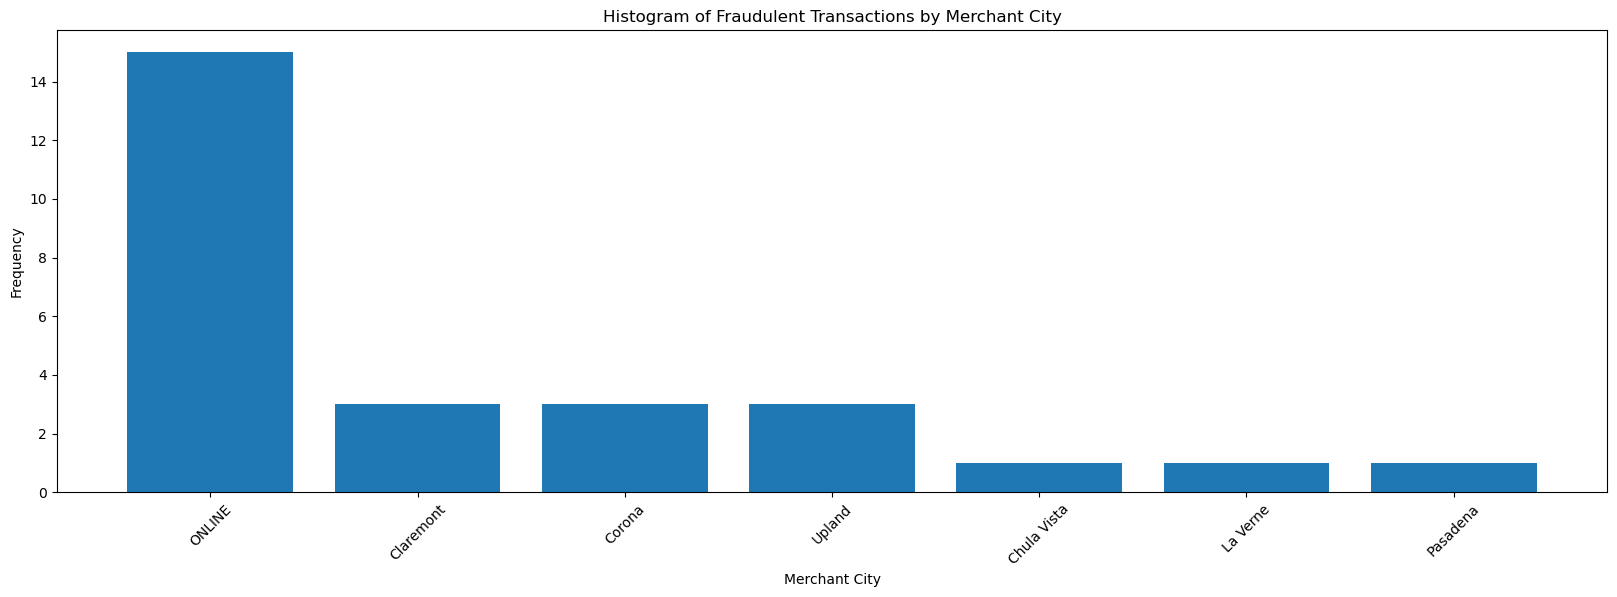

In [435]:
## check for frauds in Merchant City 
# Group fraudulent transactions by 'Merchant City' and count the number of occurrences
fraud_transactions_by_city = fraud_transactions.groupby('Merchant City')['Amount'].count().reset_index()

# Sort fraudulent transactions by count
sorted_fraud_transactions_by_city = fraud_transactions_by_city.sort_values(by='Amount', ascending=False)

# Display the sorted fraudulent transactions by 'Merchant City'
print(sorted_fraud_transactions_by_city)

# Create a histogram of fraudulent transactions by 'Merchant City'
plt.figure(figsize=(20, 6))
plt.bar(sorted_fraud_transactions_by_city['Merchant City'], sorted_fraud_transactions_by_city['Amount'])
plt.xlabel('Merchant City')
plt.ylabel('Frequency')
plt.title('Histogram of Fraudulent Transactions by Merchant City')
plt.xticks(rotation=45)
plt.show()


#### Column Merchant State

In [436]:
data['Merchant State'].value_counts(dropna=False)

CA                    17029
NaN                    1317
NJ                      186
TX                      156
Mexico                  146
MI                      125
NV                      112
NY                       95
IL                       82
FL                       77
IA                       75
MA                       58
WA                       49
Jamaica                  46
Philippines              46
UT                       33
GA                       32
Italy                    32
HI                       31
SC                       27
AK                       24
MO                       23
China                    18
MN                       16
PA                       14
Estonia                  13
AR                       13
Japan                    12
CT                       10
WI                        9
VA                        9
OH                        9
NE                        8
AZ                        7
Portugal                  6
Switzerland         

In [437]:
## check for frauds in Merchant State
## We make an asumption than Nan = Online 
## we check the Nan Values  rows 
nan_rows = data[data['Merchant State'].isna()]
#print(nan_rows)
## all are online , assumption TRUE 

In [438]:
# Replace NaN values with 'online'
data['Merchant State'] = data['Merchant State'].fillna('Online')

# Group fraudulent transactions by 'Merchant City' and count the number of occurrences
fraud_transactions_by_state = fraud_transactions.groupby('Merchant State')['Amount'].count().reset_index()

# Sort fraudulent transactions by count
sorted_fraud_transactions_by_state = fraud_transactions_by_state.sort_values(by='Amount', ascending=False)

# Display the sorted fraudulent transactions by 'Merchant State'
print(sorted_fraud_transactions_by_state)

# Create a histogram of fraudulent transactions by 'Merchant City'
#plt.figure(figsize=(20, 6))
#plt.bar(sorted_fraud_transactions_by_state['Merchant State'], sorted_fraud_transactions_by_state['Amount'])
#plt.xlabel('Merchant State')
#plt.ylabel('Frequency')
#plt.title('Histogram of Fraudulent Transactions by Merchant state')
#plt.xticks(rotation=45)
#plt.show()

  Merchant State  Amount
0             CA      12


In [439]:
## Most Frauds happened in CA and Online , we make 4 groups for marchant city
data['Merchant State'].value_counts(dropna=False)
def group_merchant_city(city):
    if city == 'Online':
        return 'Online'
    elif city == 'CA':
        return 'USA CA'
    elif len(city) == 2:
        return 'US not CA'
    else:
        return 'Outside US'
data['Merchant State_grouped'] = data['Merchant State'].apply(group_merchant_city)
data.head()

## change to state not city 

,Card,Date,Month,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Time Period,Amount_Range,Merchant Type,Merchant State_grouped
0,0,2002-09-01,9,06:21,134.0,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,Morning,0-200,in-person,USA CA
1,0,2002-09-01,9,06:42,38.0,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,Morning,0-200,in-person,USA CA
2,0,2002-09-02,9,06:22,120.0,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,Morning,0-200,in-person,USA CA
3,0,2002-09-02,9,17:45,129.0,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,Evening,0-200,in-person,USA CA
4,0,2002-09-03,9,06:23,105.0,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,Morning,0-200,in-person,USA CA


In [440]:
data['Merchant State_grouped'].value_counts()

USA CA        17029
Online         1317
US not CA      1287
Outside US      330
Name: Merchant State_grouped, dtype: int64

#### Dealing with MCC Column 

In [441]:
# MCC description mapping
mcc_description = {
     1711: "Air Conditioning Contractors – Sales and Installation, Heating Contractors – Sales, Service, Installation",
    3000: "UNITED AIRLINES",
    3001: "AMERICAN AIRLINES",
    3006: "JAPAN AIRLINES",
    3007: "AIR FRANCE",
    3008: "LUFTHANSA",
    3009: "AIR CANADA",
    3058: "DELTA",
    3066: "SOUTHWEST",
    3132: "Airlines",
    3174: "Airlines",
    3256: "ALASKA AIRLINES",
    3260: "Airlines",
    3359: "PAYLESS CAR RENTAL",
    3387: "ALAMO RENT-A-CAR",
    3389: "AVIS RENT-A-CAR",
    3390: "DOLLAR RENT-A-CAR",
    3393: "NATIONAL CAR RENTAL",
    3395: "THRIFTY RENT-A-CAR",
    3405: "ENTERPRISE RENT-A-CAR",
    3504: "HILTON HOTELS",
    3509: "MARRIOTT HOTELS",
    3596: "Hotels/Motels/Inns/Resorts",
    3640: "HYATT HOTEL",
    3684: "BUDGET HOST INNS",
    3722: "WYNDHAM HOTEL AND RESORTS",
    3730: "MGM GRAND HOTEL",
    3771: "Hotels/Motels/Inns/Resorts",
    3775: "Hotels/Motels/Inns/Resorts",
    3780: "Hotels/Motels/Inns/Resorts",
    4112: "Passenger Railways",
    4121: "Taxicabs and Limousines",
    4131: "Bus Lines, Including Charters, Tour Buses",
    4214: "Motor Freight Carriers, Moving and Storage Companies, Trucking – Local/Long Distance, Delivery Services – Local",
    4411: "Cruise and Steamship Lines",
    4511: "Airlines, Air Carriers (not listed elsewhere)",
    4722: "Travel Agencies and Tour Operations",
    4814: "Fax services, Telecommunication Services",
    4829: "Money Orders – Wire Transfer",
    4899: "Cable and other pay television (previously Cable Services)",
    4900: "Electric, Gas, Sanitary and Water Utilities",
    5094: "Precious Stones and Metals, Watches and Jewelry",
    5193: "Florists’ Supplies, Nursery Stock and Flowers",
    5211: "Lumber and Building Materials Stores",
    5251: "Hardware Stores",
    5300: "Wholesale Clubs",
    5310: "Discount Stores",
    5311: "Department Stores",
    5411: "Grocery Stores, Supermarkets",
    5499: "Misc. Food Stores – Convenience Stores and Specialty Markets",
    5533: "Automotive Parts, Accessories Stores",
    5541: "Service Stations (with or without ancillary services)",
    5621: "Women’s Ready-to-Wear Stores",
    5651: "Family Clothing Stores",
    5655: "Sports Apparel, Riding Apparel Stores",
    5661: "Shoe Stores",
    5712: "Furniture, Home Furnishings, and Equipment Stores, Except Appliances",
    5719: "Miscellaneous Home Furnishing Specialty Stores",
    5732: "Electronic Sales",
    5733: "Music Stores, Musical Instruments, Piano Sheet Music",
    5812: "Eating places and Restaurants",
    5813: "Drinking Places (Alcoholic Beverages), Bars, Taverns, Cocktail lounges, Nightclubs and Discotheques",
    5814: "Fast Food Restaurants",
    5815: "Digital Goods: Media, Books, Movies, Music",
    5816: "Digital Goods: Games",
    5912: "Drug Stores and Pharmacies",
    5921: "Package Stores – Beer, Wine, and Liquor",
    5932: "Antique Shops",
    5942: "Book Stores",
    5947: "Card Shops, Gift, Novelty, and Souvenir Shops",
    5970: "Artist’s Supply and Craft Shops",
    6300: "Insurance Sales, Underwriting, and Premiums",
    7011: "Lodging – Hotels, Motels, Resorts, Central Reservation Services (not elsewhere classified)",
    7210: "Laundry, Cleaning, and Garment Services",
    7230: "Barber and Beauty Shops",
    7349: "Cleaning and Maintenance, Janitorial Services",
    7531: "Automotive Body Repair Shops",
    7538: "Automotive Service Shops",
    7542: "Car Washes",
    7549: "Towing Services",
    7801: "Government-Licensed On-Line Casinos (On-Line Gambling)",
    7802: "Government-Licensed Horse/Dog Racing",
    7832: "Motion Picture Theaters",
    7922: "Theatrical Producers (Except Motion Pictures), Ticket Agencies",
    7995: "Betting (including Lottery Tickets, Casino Gaming Chips, Off-track Betting and Wagers at Race Tracks)",
    7996: "Amusement Parks, Carnivals, Circuses, Fortune Tellers",
    8011: "Doctors and Physicians (Not Elsewhere Classified)",
    8021: "Dentists and Orthodontists",
    8041: "Chiropractors",
    8043: "Opticians, Opticians Goods and Eyeglasses",
    8049: "Podiatrists and Chiropodists",
    8099: "Medical Services and Health Practitioners (Not Elsewhere Classified)",
    8111: "Legal Services and Attorneys",
    9402: "Postal Services – Government Only"
}

# Replace the MCC codes with their descriptions
data['MCC Type'] = data['MCC'].map(mcc_description)

In [442]:
mcc_categories = {
    "Airlines, Hotels and Lodging, Car Rentals, and Travel-Related Services": [3000, 3001, 3006, 3007, 3008, 3009, 3058, 3066, 3132, 3174, 3256, 3260, 3359, 3387, 3389, 3390, 3393, 3395, 3405, 3504, 3509, 3596, 3640, 3684, 3722, 3730, 3771, 3775, 3780, 4112, 4121, 4131, 4411, 4511, 4722, 7011],
    "Restaurants, Bars, and Other Food and Beverage Establishments": [5812, 5813, 5814, 5815],
    "Retail and Wholesale Stores": [5094, 5193, 5211, 5251, 5300, 5310, 5311, 5411, 5499, 5533, 5621, 5651, 5655, 5661, 5712, 5719, 5732, 5733, 5912, 5921, 5932, 5942, 5947, 5970],
    "Entertainment, Leisure, and Recreation": [5533, 5733, 7832, 7922],
    "Personal Care Services and Products": [7210, 7230, 7349],
    "Miscellaneous Services and Utilities": [4814, 4829, 4899, 4900, 6300, 7531, 7538, 7542, 7549, 7801, 7802, 7995]
}

## Creating a new column called MCC category 
data['MCC_Category'] = ''
# Create a function 
for category, mcc_list in mcc_categories.items():
    data['MCC_Category'] = np.where(data['MCC'].isin(mcc_list), category, data['MCC_Category'])


In [443]:
data.columns

Index(['Card', 'Date', 'Month', 'Time', 'Amount', 'Use Chip', 'Merchant Name',
       'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?',
       'Time Period', 'Amount_Range', 'Merchant Type',
       'Merchant State_grouped', 'MCC Type', 'MCC_Category'],
      dtype='object')

In [444]:
column_order = ['Card', 'Date', 'Month', 'Time','Time Period', 'Amount','Amount_Range', 'Use Chip', 'Merchant Name',
       'Merchant City','Merchant Type','Merchant State', 'Merchant State_grouped', 'Zip', 'MCC','MCC Type','MCC_Category', 'Errors?', 'Is Fraud?',
       
      ]
# reorder the columns in the DataFrame
data = data[column_order]

In [445]:
data.head()

,Card,Date,Month,Time,Time Period,Amount,Amount_Range,Use Chip,Merchant Name,Merchant City,Merchant Type,Merchant State,Merchant State_grouped,Zip,MCC,MCC Type,MCC_Category,Errors?,Is Fraud?
0,0,2002-09-01,9,06:21,Morning,134.0,0-200,Swipe Transaction,3527213246127876953,La Verne,in-person,CA,USA CA,91750.0,5300,Wholesale Clubs,Retail and Wholesale Stores,NaN,No
1,0,2002-09-01,9,06:42,Morning,38.0,0-200,Swipe Transaction,-727612092139916043,Monterey Park,in-person,CA,USA CA,91754.0,5411,"Grocery Stores, Supermarkets",Retail and Wholesale Stores,NaN,No
2,0,2002-09-02,9,06:22,Morning,120.0,0-200,Swipe Transaction,-727612092139916043,Monterey Park,in-person,CA,USA CA,91754.0,5411,"Grocery Stores, Supermarkets",Retail and Wholesale Stores,NaN,No
3,0,2002-09-02,9,17:45,Evening,129.0,0-200,Swipe Transaction,3414527459579106770,Monterey Park,in-person,CA,USA CA,91754.0,5651,Family Clothing Stores,Retail and Wholesale Stores,NaN,No
4,0,2002-09-03,9,06:23,Morning,105.0,0-200,Swipe Transaction,5817218446178736267,La Verne,in-person,CA,USA CA,91750.0,5912,Drug Stores and Pharmacies,Retail and Wholesale Stores,NaN,No


#### Use Chip Column 

In [446]:
data['Use Chip'].value_counts()  ## Looks good, nothing to edit 

Swipe Transaction     15840
Chip Transaction       2808
Online Transaction     1315
Name: Use Chip, dtype: int64

#### Column ZIP 

In [447]:
data['Zip'].value_counts() 

91750.0    10874
91752.0     2406
91754.0     1971
91755.0      893
91761.0       92
           ...  
8071.0         1
89410.0        1
89431.0        1
93101.0        1
95334.0        1
Name: Zip, Length: 415, dtype: int64

In [448]:
print(fraud_transactions.sort_values(by='Zip')) ## ZIP is same as city, check to drop. 

       Card        Date  Month   Time  Amount            Use Chip  \
13678     3  2008-10-10     10  09:37    11.0   Swipe Transaction   
9761      2  2016-03-06      3  11:18    82.0    Chip Transaction   
13688     3  2008-10-13     10  07:08    75.0   Swipe Transaction   
17738     3  2016-02-23      2  14:38    22.0   Swipe Transaction   
13684     3  2008-10-12     10  15:54    96.0   Swipe Transaction   
13687     3  2008-10-13     10  07:02     4.0   Swipe Transaction   
13690     3  2008-10-13     10  08:13   196.0   Swipe Transaction   
13683     3  2008-10-12     10  11:52    69.0   Swipe Transaction   
13689     3  2008-10-13     10  08:10   245.0   Swipe Transaction   
13685     3  2008-10-12     10  15:58   298.0   Swipe Transaction   
13698     3  2008-10-20     10  09:03    30.0   Swipe Transaction   
13699     3  2008-10-20     10  09:23  -298.0   Swipe Transaction   
4099      0  2015-11-15     11  12:55   287.0  Online Transaction   
4100      0  2015-11-15     11  13

#### Column errors

In [449]:
fraud_transactions.sort_values(by='Errors?')

,Card,Date,Month,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Time Period
4099,0,2015-11-15,11,12:55,287.0,Online Transaction,-8194607650924472520,ONLINE,NaN,NaN,3001,NaN,Yes,Open Hours
4100,0,2015-11-15,11,13:19,2.0,Online Transaction,-7759074308363763111,ONLINE,NaN,NaN,5651,NaN,Yes,Open Hours
4101,0,2015-11-16,11,09:41,51.0,Online Transaction,-551332107213382088,ONLINE,NaN,NaN,4411,NaN,Yes,Open Hours
4102,0,2015-11-16,11,09:46,248.0,Online Transaction,4872340518840476610,ONLINE,NaN,NaN,5732,NaN,Yes,Open Hours
4103,0,2015-11-16,11,11:20,473.0,Online Transaction,-8566951830324093739,ONLINE,NaN,NaN,3640,NaN,Yes,Open Hours
4104,0,2015-11-16,11,11:34,144.0,Online Transaction,-3650057525483423997,ONLINE,NaN,NaN,3007,NaN,Yes,Open Hours
4105,0,2015-11-16,11,13:44,45.0,Online Transaction,1913477460590765860,ONLINE,NaN,NaN,5300,NaN,Yes,Open Hours
4106,0,2015-11-17,11,14:12,65.0,Online Transaction,4645744106416199425,ONLINE,NaN,NaN,7996,NaN,Yes,Open Hours
4107,0,2015-11-17,11,15:35,125.0,Online Transaction,9057735476014445185,ONLINE,NaN,NaN,5311,NaN,Yes,Open Hours
4108,0,2015-11-17,11,15:59,97.0,Online Transaction,5625828905483550857,ONLINE,NaN,NaN,7922,NaN,Yes,Open Hours


In [450]:
data['Errors?'].value_counts()

Insufficient Balance            469
Technical Glitch                 46
Bad PIN                          42
Bad Expiration                    9
Bad Card Number                   4
Bad CVV                           2
Bad PIN,Insufficient Balance      1
Bad PIN,Technical Glitch          1
Name: Errors?, dtype: int64

In [451]:
error_groups = {
    'Bad PIN': 'Bad Card Information',
    'Bad Expiration': 'Bad Card Information',
    'Bad Card Number': 'Bad Card Information',
    'Bad CVV': 'Bad Card Information',
    'Insufficient Balance': 'Insufficient Balance',
    'Technical Glitch': 'Technical Glitch'
}

data['Error_Group'] = data['Errors?'].map(error_groups).fillna('No Error')

In [452]:
data.head()

,Card,Date,Month,Time,Time Period,Amount,Amount_Range,Use Chip,Merchant Name,Merchant City,Merchant Type,Merchant State,Merchant State_grouped,Zip,MCC,MCC Type,MCC_Category,Errors?,Is Fraud?,Error_Group
0,0,2002-09-01,9,06:21,Morning,134.0,0-200,Swipe Transaction,3527213246127876953,La Verne,in-person,CA,USA CA,91750.0,5300,Wholesale Clubs,Retail and Wholesale Stores,NaN,No,No Error
1,0,2002-09-01,9,06:42,Morning,38.0,0-200,Swipe Transaction,-727612092139916043,Monterey Park,in-person,CA,USA CA,91754.0,5411,"Grocery Stores, Supermarkets",Retail and Wholesale Stores,NaN,No,No Error
2,0,2002-09-02,9,06:22,Morning,120.0,0-200,Swipe Transaction,-727612092139916043,Monterey Park,in-person,CA,USA CA,91754.0,5411,"Grocery Stores, Supermarkets",Retail and Wholesale Stores,NaN,No,No Error
3,0,2002-09-02,9,17:45,Evening,129.0,0-200,Swipe Transaction,3414527459579106770,Monterey Park,in-person,CA,USA CA,91754.0,5651,Family Clothing Stores,Retail and Wholesale Stores,NaN,No,No Error
4,0,2002-09-03,9,06:23,Morning,105.0,0-200,Swipe Transaction,5817218446178736267,La Verne,in-person,CA,USA CA,91750.0,5912,Drug Stores and Pharmacies,Retail and Wholesale Stores,NaN,No,No Error


#### Merchant name column

In [453]:
data['Merchant Name'].value_counts()

-727612092139916043     1759
 4060646732831064559    1723
 5817218446178736267    1642
 2027553650310142703    1601
-34551508091458520      1542
                        ... 
 4011641048433061148       1
-6832656599657603367       1
 8962679560113522566       1
 2548810135973134041       1
-1986256106615932655       1
Name: Merchant Name, Length: 552, dtype: int64

In [454]:
fraud_transactions.sort_values(by='Merchant Name') ## Better to drop, nothing significant 

,Card,Date,Month,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Time Period
4112,0,2015-11-20,11,07:42,-473.0,Online Transaction,-8566951830324093739,ONLINE,NaN,NaN,3640,NaN,Yes,Morning
4111,0,2015-11-20,11,07:34,162.0,Online Transaction,-8566951830324093739,ONLINE,NaN,NaN,3640,NaN,Yes,Morning
4103,0,2015-11-16,11,11:20,473.0,Online Transaction,-8566951830324093739,ONLINE,NaN,NaN,3640,NaN,Yes,Open Hours
4099,0,2015-11-15,11,12:55,287.0,Online Transaction,-8194607650924472520,ONLINE,NaN,NaN,3001,NaN,Yes,Open Hours
4100,0,2015-11-15,11,13:19,2.0,Online Transaction,-7759074308363763111,ONLINE,NaN,NaN,5651,NaN,Yes,Open Hours
9761,2,2016-03-06,3,11:18,82.0,Chip Transaction,-6680087784759370261,Claremont,CA,91711.0,4121,NaN,Yes,Open Hours
4104,0,2015-11-16,11,11:34,144.0,Online Transaction,-3650057525483423997,ONLINE,NaN,NaN,3007,NaN,Yes,Open Hours
4109,0,2015-11-17,11,16:05,18.0,Online Transaction,-3220758452254689706,ONLINE,NaN,NaN,5311,NaN,Yes,Open Hours
9762,2,2016-03-06,3,12:10,298.0,Online Transaction,-3220758452254689706,ONLINE,NaN,NaN,5311,NaN,Yes,Open Hours
13689,3,2008-10-13,10,08:10,245.0,Swipe Transaction,-1396821880537214279,Chula Vista,CA,91913.0,5816,NaN,Yes,Morning


#### Dropping columns and rearraning columns 

In [455]:
data.head()

,Card,Date,Month,Time,Time Period,Amount,Amount_Range,Use Chip,Merchant Name,Merchant City,Merchant Type,Merchant State,Merchant State_grouped,Zip,MCC,MCC Type,MCC_Category,Errors?,Is Fraud?,Error_Group
0,0,2002-09-01,9,06:21,Morning,134.0,0-200,Swipe Transaction,3527213246127876953,La Verne,in-person,CA,USA CA,91750.0,5300,Wholesale Clubs,Retail and Wholesale Stores,NaN,No,No Error
1,0,2002-09-01,9,06:42,Morning,38.0,0-200,Swipe Transaction,-727612092139916043,Monterey Park,in-person,CA,USA CA,91754.0,5411,"Grocery Stores, Supermarkets",Retail and Wholesale Stores,NaN,No,No Error
2,0,2002-09-02,9,06:22,Morning,120.0,0-200,Swipe Transaction,-727612092139916043,Monterey Park,in-person,CA,USA CA,91754.0,5411,"Grocery Stores, Supermarkets",Retail and Wholesale Stores,NaN,No,No Error
3,0,2002-09-02,9,17:45,Evening,129.0,0-200,Swipe Transaction,3414527459579106770,Monterey Park,in-person,CA,USA CA,91754.0,5651,Family Clothing Stores,Retail and Wholesale Stores,NaN,No,No Error
4,0,2002-09-03,9,06:23,Morning,105.0,0-200,Swipe Transaction,5817218446178736267,La Verne,in-person,CA,USA CA,91750.0,5912,Drug Stores and Pharmacies,Retail and Wholesale Stores,NaN,No,No Error


In [456]:
data = data.drop('Merchant Name', axis=1)
data = data.drop('Merchant City', axis=1)
data = data.drop('Merchant State', axis=1)
data = data.drop('Zip', axis=1)
data = data.drop('MCC', axis=1)
data = data.drop('MCC Type', axis=1)
data = data.drop('Errors?', axis=1)


In [457]:
data.head()

,Card,Date,Month,Time,Time Period,Amount,Amount_Range,Use Chip,Merchant Type,Merchant State_grouped,MCC_Category,Is Fraud?,Error_Group
0,0,2002-09-01,9,06:21,Morning,134.0,0-200,Swipe Transaction,in-person,USA CA,Retail and Wholesale Stores,No,No Error
1,0,2002-09-01,9,06:42,Morning,38.0,0-200,Swipe Transaction,in-person,USA CA,Retail and Wholesale Stores,No,No Error
2,0,2002-09-02,9,06:22,Morning,120.0,0-200,Swipe Transaction,in-person,USA CA,Retail and Wholesale Stores,No,No Error
3,0,2002-09-02,9,17:45,Evening,129.0,0-200,Swipe Transaction,in-person,USA CA,Retail and Wholesale Stores,No,No Error
4,0,2002-09-03,9,06:23,Morning,105.0,0-200,Swipe Transaction,in-person,USA CA,Retail and Wholesale Stores,No,No Error


In [458]:
data['MCC_Category'] = data['MCC_Category'].replace('','Online Shopping')

In [459]:
data['MCC_Category'].value_counts()

Retail and Wholesale Stores                                               12831
Miscellaneous Services and Utilities                                       2307
Restaurants, Bars, and Other Food and Beverage Establishments              1849
Online Shopping                                                            1836
Airlines, Hotels and Lodging, Car Rentals, and Travel-Related Services      692
Personal Care Services and Products                                         300
Entertainment, Leisure, and Recreation                                      148
Name: MCC_Category, dtype: int64

In [460]:
data.columns

Index(['Card', 'Date', 'Month', 'Time', 'Time Period', 'Amount',
       'Amount_Range', 'Use Chip', 'Merchant Type', 'Merchant State_grouped',
       'MCC_Category', 'Is Fraud?', 'Error_Group'],
      dtype='object')

In [461]:
column_order = ['Card', 'Date', 'Month', 'Time', 'Time Period', 'Amount',
       'Amount_Range', 'Use Chip', 'Merchant Type', 'Merchant State_grouped',
       'MCC_Category', 'Error_Group','Is Fraud?']

# reorder the columns in the DataFrame
data = data[column_order]

In [462]:
data.to_csv('updated_creditCardT.csv', index=False) ## Saving the file

In [463]:
pip install xlwt


Note: you may need to restart the kernel to use updated packages.


In [464]:
data.to_excel("updated_creditCardT_1.xls", index=False)

### Features correlation

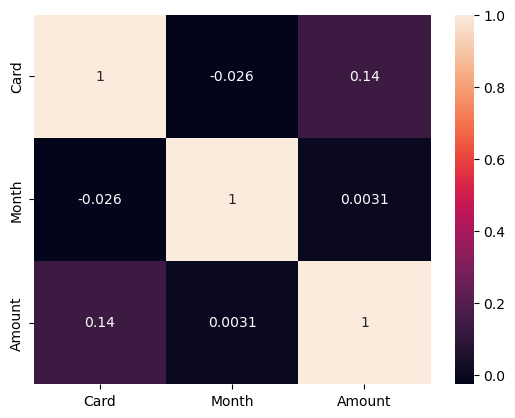

In [465]:
correlations_matrix = data.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

## Predictive models

#### Define predictors and target values (X, y) 


In [466]:
X = data.drop(['Is Fraud?','Time','Date'],axis=1)
y = data['Is Fraud?']

#### Split data in train, test and validation set

In [467]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [468]:
X_train.shape

(15970, 10)

In [469]:
X_test.shape

(3993, 10)

#### Scaling our test and train numericals

In [470]:
numericals_train = X_train.select_dtypes(np.number)
numericals_test = X_test.select_dtypes(np.number)
numericals_train.head()

,Card,Month,Amount
19273,3,12,13.0
862,0,6,1.0
11854,3,6,37.0
15058,3,4,133.0
1421,0,4,54.0


In [471]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(numericals_train)
numericals_train_standardized = pd.DataFrame(transformer.transform(numericals_train),columns=numericals_train.columns) 
numericals_test_standardized = pd.DataFrame(transformer.transform(numericals_test),columns=numericals_test.columns)

In [472]:
numericals_train_standardized.head()

,Card,Month,Amount
0,0.878308,1.568221,-0.736554
1,-1.551098,-0.164962,-0.866116
2,0.878308,-0.164962,-0.477432
3,0.878308,-0.742689,0.559060
4,-1.551098,-0.742689,-0.293886


#### Encoding our categoricals 

In [473]:
categoricals_train= X_train.select_dtypes(object)
categoricals_test= X_test.select_dtypes(object)
categoricals_train.head()

,Time Period,Amount_Range,Use Chip,Merchant Type,Merchant State_grouped,MCC_Category,Error_Group
19273,Open Hours,0-200,Online Transaction,online,Online,Retail and Wholesale Stores,No Error
862,Open Hours,0-200,Swipe Transaction,in-person,USA CA,Retail and Wholesale Stores,No Error
11854,Morning,0-200,Swipe Transaction,in-person,USA CA,Retail and Wholesale Stores,No Error
15058,Open Hours,0-200,Online Transaction,online,Online,Miscellaneous Services and Utilities,No Error
1421,Morning,0-200,Swipe Transaction,in-person,USA CA,Retail and Wholesale Stores,No Error


In [474]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(categoricals_train)
column_name = encoder.get_feature_names_out(categoricals_train.columns)
categoricals_train_encoded = pd.DataFrame(encoder.transform(categoricals_train).toarray(), columns=column_name)
categoricals_test_encoded = pd.DataFrame(encoder.transform(categoricals_test).toarray(),columns=column_name)

In [475]:
categoricals_train_encoded.head()

,Time Period_Morning,Time Period_Night,Time Period_Open Hours,Amount_Range_Less than Zero,Amount_Range_More than 200,Use Chip_Online Transaction,Use Chip_Swipe Transaction,Merchant Type_online,Merchant State_grouped_Outside US,Merchant State_grouped_US not CA,Merchant State_grouped_USA CA,"MCC_Category_Entertainment, Leisure, and Recreation",MCC_Category_Miscellaneous Services and Utilities,MCC_Category_Online Shopping,MCC_Category_Personal Care Services and Products,"MCC_Category_Restaurants, Bars, and Other Food and Beverage Establishments",MCC_Category_Retail and Wholesale Stores,Error_Group_Insufficient Balance,Error_Group_No Error,Error_Group_Technical Glitch
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


#### Concat both num and cat

In [476]:
X_train = pd.concat((numericals_train_standardized,categoricals_train_encoded),axis=1)
X_test = pd.concat((numericals_test_standardized,categoricals_test_encoded),axis=1)

In [477]:
pd.DataFrame(X_train)

,Card,Month,Amount,Time Period_Morning,Time Period_Night,Time Period_Open Hours,Amount_Range_Less than Zero,Amount_Range_More than 200,Use Chip_Online Transaction,Use Chip_Swipe Transaction,...,Merchant State_grouped_USA CA,"MCC_Category_Entertainment, Leisure, and Recreation",MCC_Category_Miscellaneous Services and Utilities,MCC_Category_Online Shopping,MCC_Category_Personal Care Services and Products,"MCC_Category_Restaurants, Bars, and Other Food and Beverage Establishments",MCC_Category_Retail and Wholesale Stores,Error_Group_Insufficient Balance,Error_Group_No Error,Error_Group_Technical Glitch
0,0.878308,1.568221,-0.736554,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-1.551098,-0.164962,-0.866116,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.878308,-0.164962,-0.477432,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.878308,-0.742689,0.559060,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.551098,-0.742689,-0.293886,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15965,0.878308,0.412766,-0.196715,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
15966,-1.551098,0.701630,-0.283089,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15967,0.878308,1.279357,0.699418,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
15968,0.878308,0.412766,-0.477432,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


#### Trying to Balance the Data

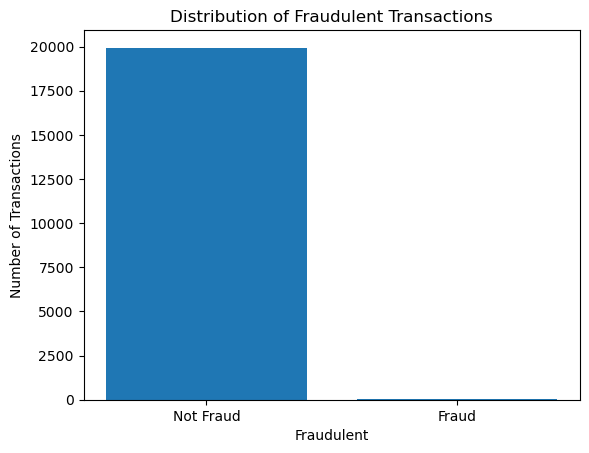

In [478]:
# create a bar plot of is fraud? column
plt.bar(['Not Fraud', 'Fraud'], data['Is Fraud?'].value_counts())
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Fraudulent')
plt.ylabel('Number of Transactions')
plt.show()

### OverSampling

In [479]:
X_train.head()

,Card,Month,Amount,Time Period_Morning,Time Period_Night,Time Period_Open Hours,Amount_Range_Less than Zero,Amount_Range_More than 200,Use Chip_Online Transaction,Use Chip_Swipe Transaction,...,Merchant State_grouped_USA CA,"MCC_Category_Entertainment, Leisure, and Recreation",MCC_Category_Miscellaneous Services and Utilities,MCC_Category_Online Shopping,MCC_Category_Personal Care Services and Products,"MCC_Category_Restaurants, Bars, and Other Food and Beverage Establishments",MCC_Category_Retail and Wholesale Stores,Error_Group_Insufficient Balance,Error_Group_No Error,Error_Group_Technical Glitch
0,0.878308,1.568221,-0.736554,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-1.551098,-0.164962,-0.866116,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.878308,-0.164962,-0.477432,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.878308,-0.742689,0.559060,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.551098,-0.742689,-0.293886,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [480]:
y_train.head()

19273    No
862      No
11854    No
15058    No
1421     No
Name: Is Fraud?, dtype: object

In [481]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [482]:
# oversampling / undersampling is only to be done on the TRAINING set
# our test set still must reflect reality!
train = pd.concat([X_train, y_train],axis=1)
train.head()


,Card,Month,Amount,Time Period_Morning,Time Period_Night,Time Period_Open Hours,Amount_Range_Less than Zero,Amount_Range_More than 200,Use Chip_Online Transaction,Use Chip_Swipe Transaction,...,"MCC_Category_Entertainment, Leisure, and Recreation",MCC_Category_Miscellaneous Services and Utilities,MCC_Category_Online Shopping,MCC_Category_Personal Care Services and Products,"MCC_Category_Restaurants, Bars, and Other Food and Beverage Establishments",MCC_Category_Retail and Wholesale Stores,Error_Group_Insufficient Balance,Error_Group_No Error,Error_Group_Technical Glitch,Is Fraud?
0,0.878308,1.568221,-0.736554,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
1,-1.551098,-0.164962,-0.866116,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
2,0.878308,-0.164962,-0.477432,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
3,0.878308,-0.742689,0.559060,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No
4,-1.551098,-0.742689,-0.293886,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No


In [483]:
# separate majority/minority classes
no_fraud = train[train['Is Fraud?']=='No']
yes_fraud = train[train['Is Fraud?']=='Yes']

In [484]:
no_fraud

,Card,Month,Amount,Time Period_Morning,Time Period_Night,Time Period_Open Hours,Amount_Range_Less than Zero,Amount_Range_More than 200,Use Chip_Online Transaction,Use Chip_Swipe Transaction,...,"MCC_Category_Entertainment, Leisure, and Recreation",MCC_Category_Miscellaneous Services and Utilities,MCC_Category_Online Shopping,MCC_Category_Personal Care Services and Products,"MCC_Category_Restaurants, Bars, and Other Food and Beverage Establishments",MCC_Category_Retail and Wholesale Stores,Error_Group_Insufficient Balance,Error_Group_No Error,Error_Group_Technical Glitch,Is Fraud?
0,0.878308,1.568221,-0.736554,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
1,-1.551098,-0.164962,-0.866116,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
2,0.878308,-0.164962,-0.477432,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
3,0.878308,-0.742689,0.559060,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No
4,-1.551098,-0.742689,-0.293886,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15965,0.878308,0.412766,-0.196715,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,No
15966,-1.551098,0.701630,-0.283089,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No
15967,0.878308,1.279357,0.699418,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
15968,0.878308,0.412766,-0.477432,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No


In [485]:
# oversample minority
yes_fraud_oversampled = resample(yes_fraud, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(no_fraud),#<- make both sets the same size
                                    random_state=0)

In [486]:
# both sets are now of a reasonable size
display(no_fraud.shape)
display(yes_fraud_oversampled.shape)
yes_fraud_oversampled.head(20)

(15948, 24)

(15948, 24)

,Card,Month,Amount,Time Period_Morning,Time Period_Night,Time Period_Open Hours,Amount_Range_Less than Zero,Amount_Range_More than 200,Use Chip_Online Transaction,Use Chip_Swipe Transaction,...,"MCC_Category_Entertainment, Leisure, and Recreation",MCC_Category_Miscellaneous Services and Utilities,MCC_Category_Online Shopping,MCC_Category_Personal Care Services and Products,"MCC_Category_Restaurants, Bars, and Other Food and Beverage Establishments",MCC_Category_Retail and Wholesale Stores,Error_Group_Insufficient Balance,Error_Group_No Error,Error_Group_Technical Glitch,Is Fraud?
8829,0.878308,0.990493,-0.758148,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Yes
11010,0.878308,0.990493,-0.131934,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Yes
15909,-1.551098,1.279357,-0.682570,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Yes
325,0.878308,-1.320417,-0.639383,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Yes
2977,-1.551098,1.279357,-0.855319,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Yes
2977,-1.551098,1.279357,-0.855319,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Yes
5573,0.878308,0.990493,-0.067154,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Yes
6084,0.068506,-1.031553,0.008424,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Yes
14633,-1.551098,1.279357,-0.391057,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Yes
15909,-1.551098,1.279357,-0.682570,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Yes


In [487]:
display(yes_fraud_oversampled.shape)

(15948, 24)

In [488]:
display(no_fraud.shape)

(15948, 24)

In [489]:
train_oversampled = pd.concat([no_fraud,yes_fraud_oversampled],axis=0)
train_oversampled.head()

,Card,Month,Amount,Time Period_Morning,Time Period_Night,Time Period_Open Hours,Amount_Range_Less than Zero,Amount_Range_More than 200,Use Chip_Online Transaction,Use Chip_Swipe Transaction,...,"MCC_Category_Entertainment, Leisure, and Recreation",MCC_Category_Miscellaneous Services and Utilities,MCC_Category_Online Shopping,MCC_Category_Personal Care Services and Products,"MCC_Category_Restaurants, Bars, and Other Food and Beverage Establishments",MCC_Category_Retail and Wholesale Stores,Error_Group_Insufficient Balance,Error_Group_No Error,Error_Group_Technical Glitch,Is Fraud?
0,0.878308,1.568221,-0.736554,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
1,-1.551098,-0.164962,-0.866116,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
2,0.878308,-0.164962,-0.477432,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No
3,0.878308,-0.742689,0.559060,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No
4,-1.551098,-0.742689,-0.293886,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,No


In [490]:
y_train_over = train_oversampled['Is Fraud?'].copy()
X_train_over = train_oversampled.drop('Is Fraud?',axis = 1).copy()

In [491]:
# Instantiate the model with the right solver and regularization strength
LR_over = LogisticRegression(random_state=1, solver='lbfgs')

# Fit the model to the training data
LR_over.fit(X_train_over, y_train_over)

# Use the model to make predictions on the test data
pred = LR_over.predict(X_test)

print("precision: ",precision_score(y_test,pred, pos_label="Yes"))
print("recall: ",recall_score(y_test,pred, pos_label="Yes"))
print("f1: ",f1_score(y_test,pred, pos_label="Yes"))


precision:  0.011441647597254004
recall:  1.0
f1:  0.022624434389140267


In [492]:
LR_over.score(X_test, y_test)

0.8918106686701728

In [503]:
from sklearn.metrics import confusion_matrix
LR_confusion_matrix = confusion_matrix(y_test,pred)
LR_confusion_matrix

array([[3556,  432],
       [   0,    5]])

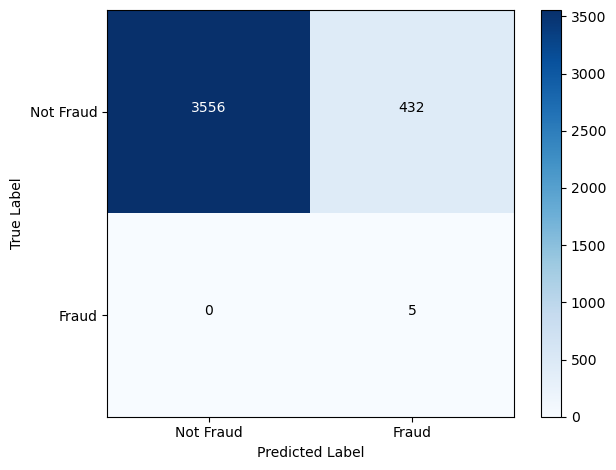

In [506]:
confusion_matrix= LR_confusion_matrix



plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()

# Add ticks and labels for clarity
tick_marks = np.arange(len(['Not Fraud', 'Fraud']))
plt.xticks(tick_marks, ['Not Fraud', 'Fraud'])
plt.yticks(tick_marks, ['Not Fraud', 'Fraud'])

# Add annotations for each cell
thresh = confusion_matrix.max() / 2.
for i, j in np.ndindex(confusion_matrix.shape):
    plt.text(j, i, format(confusion_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
y_test.value_counts()

In [523]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=130, weights='distance',algorithm='kd_tree')
# Fit the model to the training data
clf.fit(X_train_over, y_train_over)
# Use the model on our test sata and make predictions
predictions_clf = clf.predict(X_test)
clf.score(X_test, y_test)

0.9711995992987729

In [524]:
from sklearn.metrics import confusion_matrix
#Create a confusion matrix to check predictions
cm = confusion_matrix(y_test, predictions_clf)
print(cm)


[[3873  115]
 [   0    5]]


In [525]:
#Accuracy scroe 

clf.score(X_test, y_test)

0.9711995992987729

In [526]:
print("precision: ",precision_score(y_test,predictions_clf, pos_label="Yes"))
print("recall: ",recall_score(y_test,predictions_clf, pos_label="Yes"))
print("f1: ",f1_score(y_test,predictions_clf, pos_label="Yes"))

precision:  0.041666666666666664
recall:  1.0
f1:  0.07999999999999999


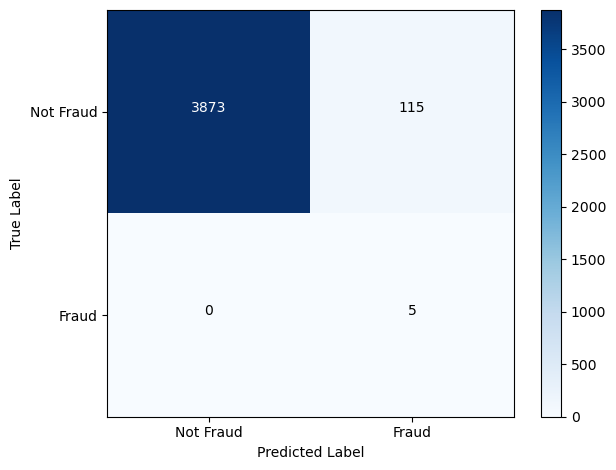

In [527]:
confusion_matrix1 = cm

plt.imshow(confusion_matrix1, cmap='Blues')
plt.colorbar()

# Add ticks and labels for clarity
tick_marks = np.arange(len(['Not Fraud', 'Fraud']))
plt.xticks(tick_marks, ['Not Fraud', 'Fraud'])
plt.yticks(tick_marks, ['Not Fraud', 'Fraud'])

# Add annotations for each cell
thresh = confusion_matrix1.max() / 2.
for i, j in np.ndindex(confusion_matrix1.shape):
    plt.text(j, i, format(confusion_matrix1[i, j], 'd'),
             horizontalalignment="center",
             color="white" if confusion_matrix1[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Conclusion  